<a href="https://colab.research.google.com/github/vacheharutyunyan/machine-learning-projects/blob/main/BinaryClassificationWithResNet_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework: The Transfer Learning Challenge 🐝 vs 🐜
## The Challenge:
You are given a very small dataset (~120 images) of Ants and Bees.
Your goal is to build a classifier that distinguishes between them.

## The Catch:
If you train a CNN from scratch on this small dataset, you will likely struggle to get past 60-70% accuracy (Overfitting).
To get a high score (>90%), you MUST use Transfer Learning (Fine-Tuning a ResNet).

Tasks:
1. Setup DataLoaders with Data Augmentation.
2. Load a Pre-trained ResNet-18.
3. Modify the final layer to output 2 classes.
4. Train the model and beat the baseline!

In [1]:
import os
import zipfile
import requests

# Download the Hymenoptera Dataset (Standard PyTorch Tutorial Dataset)
# This dataset contains roughly 120 training images each for ants and bees.
data_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_path = "./hymenoptera_data"

if not os.path.exists(data_path):
    print("Downloading dataset...")
    r = requests.get(data_url)
    with open("data.zip", "wb") as f:
        f.write(r.content)

    print("Unzipping...")
    with zipfile.ZipFile("data.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    print("Done!")
else:
    print("Dataset already exists.")

Unzipping...
Done!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# TODO: Define your transforms
# Hint: You MUST resize images to 224x224 for ResNet.
# Hint: For 'train', use RandomHorizontalFlip and RandomResizedCrop for augmentation.
# Hint: For 'val', just Resize and CenterCrop.
data_transforms = {
    'train': transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
      )
    ]),
    'val': transforms.Compose([
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
      )
     ]),
}

# Load the datasets
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")

Classes: ['ants', 'bees']
Training samples: 244


In [6]:
def get_model(fine_tune=True):

    model = models.resnet18(pretrained=True)
    if not fine_tune:
      for param in model.parameters():
        param.requires_grad = False

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)

    for name, param in model.named_parameters():
      print(name, param.requires_grad)

    return model.to(device)

model = get_model(fine_tune=True)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.weight True
layer2.1.bn1.weight True
layer2.1.bn1.bias True
layer2.1.conv2.weight True
layer2.1.bn2.weight True
layer2.1.bn2.bias True
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
layer3.0.downsample.1.bias True
la

In [8]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

    print(f'Best val Acc: {best_acc:4f}')
    return model

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()

# Note: If fine-tuning, we optimize all params. If feature extraction, only model.fc.parameters()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Start Training
model_ft = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5160 Acc: 0.7459
val Loss: 0.2593 Acc: 0.9020
Epoch 1/9
----------
train Loss: 0.5578 Acc: 0.7746
val Loss: 0.5425 Acc: 0.8170
Epoch 2/9
----------
train Loss: 0.5083 Acc: 0.7951
val Loss: 0.2805 Acc: 0.9085
Epoch 3/9
----------
train Loss: 0.4317 Acc: 0.8156
val Loss: 0.2710 Acc: 0.8889
Epoch 4/9
----------
train Loss: 0.4164 Acc: 0.8279
val Loss: 0.3330 Acc: 0.9150
Epoch 5/9
----------
train Loss: 0.4083 Acc: 0.8648
val Loss: 0.3433 Acc: 0.9020
Epoch 6/9
----------
train Loss: 0.4598 Acc: 0.8361
val Loss: 0.2784 Acc: 0.9216
Epoch 7/9
----------
train Loss: 0.5264 Acc: 0.8074
val Loss: 0.5167 Acc: 0.8105
Epoch 8/9
----------
train Loss: 0.6872 Acc: 0.7869
val Loss: 0.5929 Acc: 0.8562
Epoch 9/9
----------
train Loss: 0.5046 Acc: 0.8156
val Loss: 0.4065 Acc: 0.8627
Best val Acc: 0.921569


## Visualize Predictions
Write a small script to grab a batch of validation images, run them through your best model, and display the image with the predicted label vs. the actual label.

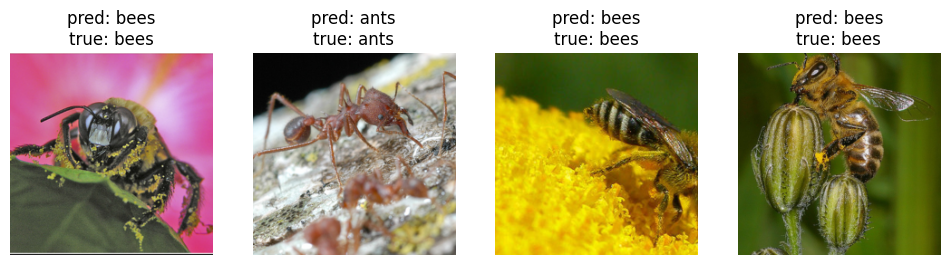

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, labels = next(iter(dataloaders['val']))

inputs = inputs.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

inputs = inputs.cpu()
labels = labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(12, 8))
for i in range(len(inputs)):
    plt.subplot(2, 4, i+1)
    imshow(inputs[i], title=f"pred: {class_names[preds[i]]}\ntrue: {class_names[labels[i]]}")
plt.show()

## Build an Ant/Bee Search Engine 🔍
Now that your model has learned to distinguish Ants from Bees, it has learned specific features (wings, legs, thorax shapes) that are unique to these insects.

### Your Goal:
Use your trained model to find images that are visually similar to a query image.

### Steps:

1. Surgery: Remove the final classification layer (model.fc) from your best model. It should now output a 512-dimensional vector (the embedding) instead of 2 class scores.

2. Indexing: Pass the entire Validation Set through this modified model and store the embeddings.

3. Search:

    * Pick a random image from the validation set as your Query.
    * Calculate the Cosine Similarity between your Query and all other images.
    * Display the Query image side-by-side with its Top 3 most similar matches.

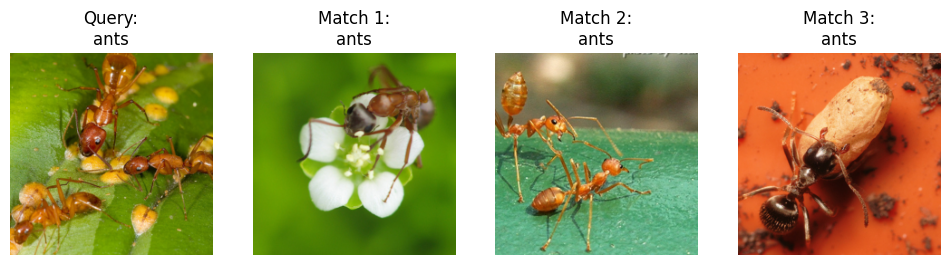

In [15]:
import torch.nn.functional as F
import random

embedding_model = model_ft
embedding_model.fc = nn.Identity()
embedding_model.eval()
embedding_model = embedding_model.to(device)

all_embeddings = []
all_labels = []
all_images = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        embeddings = embedding_model(inputs)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)
        all_images.append(inputs.cpu())

all_embeddings = torch.cat(all_embeddings)
all_labels = torch.cat(all_labels)
all_images = torch.cat(all_images)

query_idx = random.randint(0, all_embeddings.size(0)-1)
query_embedding = all_embeddings[query_idx].unsqueeze(0)
query_image = all_images[query_idx]
query_label = all_labels[query_idx]

cos = nn.CosineSimilarity(dim=1)
similarities = cos(query_embedding, all_embeddings)

similarities[query_idx] = -1.0
top3_idx = similarities.topk(3).indices

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
imshow(query_image, title=f"Query:\n{class_names[query_label]}")

for i, idx in enumerate(top3_idx):
    plt.subplot(1,4,i+2)
    imshow(all_images[idx], title=f"Match {i+1}:\n{class_names[all_labels[idx]]}")

plt.show()